<a href="https://colab.research.google.com/github/prav2909/Machine-Learning/blob/master/Classification_TransferLearning_CatastrophicForgetting_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Implementation of classification using MNIST dataset
We can simply import all required packages and load some data set using Keras.

In [1]:
import tensorflow as tf
import tensorflow.keras as k
import numpy as np
import matplotlib.pyplot as plt

# Define constants
batch_size = 128
epochs = 20
learning_rate = 0.001

(x_train_mnist, y_train_mnist), (x_test_mnist, y_test_mnist) = tf.keras.datasets.mnist.load_data()
print(np.shape(x_train_mnist))
x_train_mnist = np.expand_dims(x_train_mnist, axis=-1).astype(np.float32)
print(np.shape(x_train_mnist))
x_test_mnist = np.expand_dims(x_test_mnist, axis=-1).astype(np.float32)
print(np.shape(y_train_mnist))

11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)
(60000, 28, 28, 1)
(60000,)


We can also plot some examples in order to get an impresion of what the data looks like.

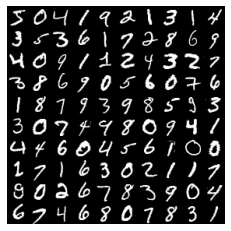

In [2]:
plt_img = np.zeros((280, 280))
for i in range(10):
  for j in range(10):
    plt_img[i*28:(i+1)*28, j*28:(j+1)*28] = np.squeeze(x_train_mnist[i*10+j])
plt.imshow(plt_img, cmap="gray")
plt.axis("off")
plt.show()

We again derive a class for our model from the Keras Model class.

In [3]:
""" We define a small convolutional network for classification with two conv. and 3 dense layers. The conv. layers should have 8/16 filters a kernel size of 3x3 and a stride of 2. The dense layers have 128/64/10 
neurons."""

class MyModel(k.Model):
    def __init__(self):
        # Layer definition
        super(MyModel, self).__init__()
        self.conv0 = k.layers.Conv2D(8, 3, strides = 2, activation="relu")
        self.conv1 = k.layers.Conv2D(16, 3, strides = 2, activation="relu")
        self.flatten = k.layers.Flatten()
        self.dense1 = k.layers.Dense(128, activation = "relu")
        self.dense2 = k.layers.Dense(64, activation = "relu")
        self.dense3 = k.layers.Dense(10, activation = "softmax")
        

    def call(self, inputs, training=False):
        # Implement a forward pass
        output = self.conv0(inputs)
        output = self.conv1(output)
        output = self.flatten(output)
        output = self.dense1(output)
        output = self.dense2(output)
        output = self.dense3(output)
        return output

We can now instanciate an object of this class and compile it using the the cross-entropy loss function.

In [4]:
""" Instantiate an object of MyModel and an RMSprop optimizer with learning rate given by the constant "learning_rate". """

mdl = MyModel()
opt = tf.optimizers.RMSprop(learning_rate)
mdl.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=['accuracy']) 

Now we are ready to train the model and log the metrics for plotting.

In [5]:
""" Train the model mdl on the training data with a batch size of "batch_size" for "epochs" epochs. Train with 10% of the training data as validation data. """

history_no_dropout = mdl.fit(x_train_mnist, y_train_mnist, batch_size=batch_size, epochs=epochs, validation_split = 0.1)

Epoch 1/20
422/422 [==============================] - 2s 6ms/step - loss: 0.5596 - accuracy: 0.8831 - val_loss: 0.1474 - val_accuracy: 0.9585
Epoch 2/20
422/422 [==============================] - 2s 5ms/step - loss: 0.1128 - accuracy: 0.9663 - val_loss: 0.1239 - val_accuracy: 0.9715
Epoch 3/20
422/422 [==============================] - 2s 5ms/step - loss: 0.0678 - accuracy: 0.9794 - val_loss: 0.0886 - val_accuracy: 0.9785
Epoch 4/20
422/422 [==============================] - 2s 5ms/step - loss: 0.0464 - accuracy: 0.9851 - val_loss: 0.0912 - val_accuracy: 0.9770
Epoch 5/20
422/422 [==============================] - 2s 5ms/step - loss: 0.0351 - accuracy: 0.9890 - val_loss: 0.0890 - val_accuracy: 0.9802
Epoch 6/20
422/422 [==============================] - 2s 5ms/step - loss: 0.0259 - accuracy: 0.9915 - val_loss: 0.1017 - val_accuracy: 0.9788
Epoch 7/20
422/422 [==============================] - 2s 5ms/step - loss: 0.0221 - accuracy: 0.9929 - val_loss: 0.0947 - val_accuracy: 0.9810
Epoch 

Visualizing the training process in a plot is possible by using the history object that contains a history dictionary. This is returned from the fit function and contains all the metrics logged over the training proces.

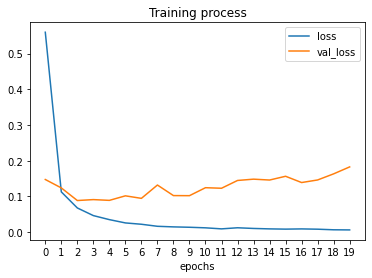

In [6]:
plt.plot(history_no_dropout.history["loss"])
plt.plot(history_no_dropout.history["val_loss"])
plt.legend(["loss", "val_loss"])
plt.xticks(range(epochs))
plt.xlabel("epochs")
plt.title("Training process")
plt.show()

As you can see, the model is clearly overfitting. The loss on the training data is decreasing further and further with every epoch, while the loss on the validation data rises at the same time. We can avoid this by using dropout, which is a strong regularization. For this we define a new model that has an additional dropout layer with a drop probability of $0.25$ before the first fully connected layer. Otherwise this model is the same as the model above.

In [7]:
""" Create a new model, which is identical to MyModel execpt for a dropout layer between the conv. and dense layers. As a dropout rate use 0.25 """

class MyDropoutModel(k.Model):
    def __init__(self):
        # Layer definition
        super(MyDropoutModel, self).__init__()
        self.conv0 = k.layers.Conv2D(8, 3, strides = 2, activation="relu")
        self.conv1 = k.layers.Conv2D(16, 3, strides = 2, activation="relu")
        self.flatten = k.layers.Flatten()
        self.dropout = k.layers.Dropout(0.25)
        self.dense1 = k.layers.Dense(128, activation = "relu")
        self.dense2 = k.layers.Dense(64, activation = "relu")
        self.dense3 = k.layers.Dense(10, activation = "softmax")
        

    def call(self, inputs, training=False):
        # Implement the forward pass
        output = self.conv0(inputs)
        output = self.conv1(output)
        output = self.flatten(output)
        output = self.dropout(output, training=training)
        output = self.dense1(output)
        output = self.dense2(output)
        output = self.dense3(output)
        return output

We can now create an instance of this model, train it and visualize the training process.

Epoch 1/20
422/422 [==============================] - 2s 6ms/step - loss: 0.8794 - accuracy: 0.8365 - val_loss: 0.1328 - val_accuracy: 0.9600
Epoch 2/20
422/422 [==============================] - 2s 5ms/step - loss: 0.1744 - accuracy: 0.9468 - val_loss: 0.0787 - val_accuracy: 0.9772
Epoch 3/20
422/422 [==============================] - 2s 5ms/step - loss: 0.1252 - accuracy: 0.9615 - val_loss: 0.0751 - val_accuracy: 0.9762
Epoch 4/20
422/422 [==============================] - 2s 5ms/step - loss: 0.1012 - accuracy: 0.9686 - val_loss: 0.0617 - val_accuracy: 0.9808
Epoch 5/20
422/422 [==============================] - 2s 5ms/step - loss: 0.0876 - accuracy: 0.9734 - val_loss: 0.0664 - val_accuracy: 0.9828
Epoch 6/20
422/422 [==============================] - 2s 5ms/step - loss: 0.0768 - accuracy: 0.9768 - val_loss: 0.0623 - val_accuracy: 0.9828
Epoch 7/20
422/422 [==============================] - 2s 5ms/step - loss: 0.0689 - accuracy: 0.9787 - val_loss: 0.0537 - val_accuracy: 0.9858
Epoch 

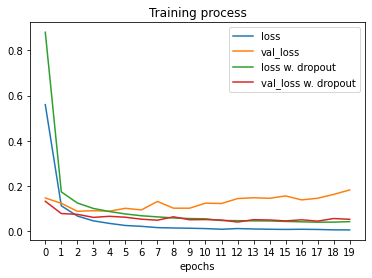

In [23]:
""" Instantiate a MyDropoutModel object, compile and train it on the training data. """

dropout_mdl = MyDropoutModel()
dropout_opt = tf.optimizers.RMSprop(learning_rate)
dropout_mdl.compile(optimizer = opt, loss="sparse_categorical_crossentropy", metrics=['accuracy'])

history_dropout = dropout_mdl.fit(x_train_mnist, y_train_mnist, batch_size=batch_size, epochs=epochs, validation_split = 0.1)

plt.plot(history_no_dropout.history["loss"])
plt.plot(history_no_dropout.history["val_loss"])
plt.plot(history_dropout.history["loss"])
plt.plot(history_dropout.history["val_loss"])
plt.legend(["loss", "val_loss", "loss w. dropout", "val_loss w. dropout"])
plt.xticks(range(epochs))
plt.xlabel("epochs")
plt.title("Training process")
plt.show()

## Transfer Learning
In transfer learning the goal is to transfer knowledge from a source domain or task to a target domain or task. The hope is that this transfer will be positive, i.e. the performance on the target domain or task increases compared to only training on the target data set. A requirement for succesfull transfer learning is that the source and target have something in common, e.g. similar features. We will a simple approach in transfer learning called fine tuning. Fine tuning can be implemented by using a part of a neural network, which was trained on the source domain or task, as a feature extractor. A common approach is to use neral network pretrained on the ImageNet data set as a feature extractor. In this exercise, we will also use a neural network pretrained on ImageNet in order to fine tune it for the [Caltech 101](http://www.vision.caltech.edu/Image_Datasets/Caltech101/) data set. For a guide on transfer learning using fine tuning with Keras click [here](https://www.tensorflow.org/beta/tutorials/images/transfer_learning).

In order to do this we first download the Caltech101 dataset.

In [9]:
!wget -N http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz
!tar -xzf 101_ObjectCategories.tar.gz

--2020-06-26 12:57:06--  http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz
Resolving www.vision.caltech.edu (www.vision.caltech.edu)... 34.208.54.77
Connecting to www.vision.caltech.edu (www.vision.caltech.edu)|34.208.54.77|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 131740031 (126M) [application/x-tar]
Saving to: ‘101_ObjectCategories.tar.gz’

101_ObjectCategorie 100%[===================>] 125.64M  1.37MB/s    in 92s     

2020-06-26 12:58:39 (1.36 MB/s) - ‘101_ObjectCategories.tar.gz’ saved [131740031/131740031]



In order to feed our model with the data, we will use the ImageDataGenerator class provided by Keras.

In [10]:
N_samples_Caltech101 = 9144
val_split = 0.1
datagen = k.preprocessing.image.ImageDataGenerator(validation_split=val_split,
                                                   preprocessing_function=k.applications.mobilenet_v2.preprocess_input,
                                                   rotation_range=20,
                                                   width_shift_range=0.1,
                                                   height_shift_range=0.1,
                                                   shear_range=0.1,
                                                   zoom_range=0.1,
                                                   horizontal_flip=True)

We will use the MobileNetV2 architecture without it's output layer, since we want to modify it in order to apply the model to the Caltech 101 data set.

In [11]:
""" Instantiate a MobileNetV2 with weights pretrained on ImageNet and without the top/output layer. Hint: Use Keras Applications"""

base_model = tf.keras.applications.MobileNetV2(include_top=False,
                                               weights='imagenet')
base_model.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, None, None, 3 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, None, None, 3 128         Conv1[0][0]                      
________________

With the pretrained model we can build our actual model that adds an output layer to the MobileNetV2.

In [12]:
""" We create a transfer learning model, that uses a pretrained model "pretrained_model" and appends a 2D global average pooling layer, a dropout layer (droprate 0.25) and a dense output layer with 102 neurons. """

class MyTransferModel(k.Model):
    def __init__(self, pretrained_model):
        super(MyTransferModel, self).__init__()
        self.pretrained_model = pretrained_model
        self.global_average_layer = k.layers.GlobalAveragePooling2D()
        self.dropout = k.layers.Dropout(0.25)
        self.dense = k.layers.Dense(102, activation = "softmax")
        # Define layers and pretrained model

    def call(self, inputs, training=False):
        # Call pretrained model and layers appropriately to implement forward pass
        output = self.pretrained_model(inputs)
        output = self.global_average_layer(output)
        output = self.dropout(output, training)
        output = self.dense(output)
        return output

Now we just need to instantiate our model for transfer learning and fine tune it. But instead of directly training all layers we will just train the last layer first. If we do not do this and directly train the complete model, the random initialization of the last layer can cause gradients with very big magnitude that will be propageted into the MobileNetV2 layers and cause them to "forget" what they have learned on ImageNet. This is undesireable since we want to transfer that knowledge over into our model in order to achieve better performance on the Caltech 101 data set.

In [13]:
""" Instantiate a MyTransferModel object and a RMSprop optimizer, compile them with a suitable loss and accuracy as a metric. Use "base_model" as the pretrained model. """

tf_batch_size = 32
tf_epochs = 10
tf_learning_rate = 0.001
tf_mdl = MyTransferModel(base_model)
tf_opt = tf.optimizers.RMSprop(tf_learning_rate)
base_model.trainable = False
tf_mdl.compile(optimizer = tf_opt, loss="sparse_categorical_crossentropy", metrics=['accuracy'])
tf_mdl.build((tf_batch_size, 224, 224, 3))
tf_mdl.summary()

#We create the data set generators and train the model for "tf_epochs" epochs
train_gen = datagen.flow_from_directory('./101_ObjectCategories',batch_size=tf_batch_size, class_mode='sparse', subset="training")
val_gen = datagen.flow_from_directory('./101_ObjectCategories',batch_size=tf_batch_size, class_mode='sparse', subset="validation")
tf_history_0 = tf_mdl.fit(train_gen, steps_per_epoch = int((1.0-val_split)*N_samples_Caltech101/tf_batch_size), batch_size=tf_batch_size, epochs = tf_epochs, 
                          validation_data = val_gen, validation_steps = 10)

Model: "my_transfer_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, None, None, 1280)  2257984   
_________________________________________________________________
global_average_pooling2d (Gl multiple                  0         
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
dense_6 (Dense)              multiple                  130662    
Total params: 2,388,646
Trainable params: 130,662
Non-trainable params: 2,257,984
_________________________________________________________________
Found 8278 images belonging to 102 classes.
Found 866 images belonging to 102 classes.
Epoch 1/10
257/257 [==============================] - 147s 572ms/step - loss: 1.3791 - accuracy: 0.7005 - val_loss: 0.4856 - val_accuracy: 0.868

Now that we have trained the outputlayer of our model on the Caltech 101 data set, we can make the last layers of the MobileNetV2 model trainable and continue to fine tune  it with a low learning rate. For this we need to recompile our model in order for the change of the MobileNetV2 parameters to trainable to have an effect.

In [14]:
tf_learning_rate = 0.00001
tf_opt = tf.optimizers.RMSprop(tf_learning_rate)
# Set base_model to be trainable
base_model.trainable = True
tf_mdl.compile(loss="sparse_categorical_crossentropy", optimizer=tf_opt, metrics=["accuracy"])
tf_mdl.build((tf_batch_size, 224, 224, 3))
tf_mdl.summary()

tf_history_1 = tf_mdl.fit(train_gen, steps_per_epoch = int((1.0-val_split)*N_samples_Caltech101/tf_batch_size), batch_size=tf_batch_size, epochs = tf_epochs, 
                          validation_data = val_gen, validation_steps = 10)

Model: "my_transfer_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, None, None, 1280)  2257984   
_________________________________________________________________
global_average_pooling2d (Gl multiple                  0         
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
dense_6 (Dense)              multiple                  130662    
Total params: 2,388,646
Trainable params: 2,354,534
Non-trainable params: 34,112
_________________________________________________________________
Epoch 1/10
257/257 [==============================] - 181s 703ms/step - loss: 0.4772 - accuracy: 0.8655 - val_loss: 0.4650 - val_accuracy: 0.8687
Epoch 2/10
257/257 [==============================] - 180s 699ms/step - loss: 0.2136 -

As can be see from the increasing gap between training and validation loss and accuracy, overfitting is becoming a bigger problem now. This is due to the much higher number of trainable parameters if we not only train the output layer on the rather small Caltech 101 data set. But still we can improve the performance of our model. We can visualize this if we plot the accuracy over the training process.

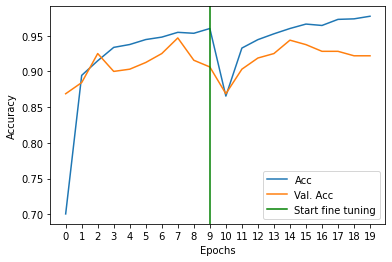

In [15]:
plt.plot(tf_history_0.history["accuracy"]+tf_history_1.history["accuracy"])
plt.plot(tf_history_0.history["val_accuracy"]+tf_history_1.history["val_accuracy"])
plt.xticks(range(len(tf_history_0.history["accuracy"]+tf_history_1.history["accuracy"])))
plt.axvline(9, color="green")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Acc", "Val. Acc", "Start fine tuning"])
plt.show()


Overall the resulting performance of the model is quite close to published results on the Caltach 101, e.g. this [paper](https://arxiv.org/abs/1406.4729v1), while the definintion and training of the model only required very little code.

In order to evaluate if transfer learning actually makes a difference, we can simply train the MobileNetV2 on the Caltech 101 data set. 

In [16]:
""" Instantiate a new base_model, now with randomly initialized weights, and instantiate a new MyTransferModel object  """

tf_batch_size = 32
tf_epochs = 5
tf_learning_rate = 0.001
base_model = tf.keras.applications.MobileNetV2(include_top=False, weights=None) # Instantiate a randomly initialized MobileNetV2 without it's top/output layer
tf_mdl =  MyTransferModel(base_model)
tf_opt = k.optimizers.RMSprop(learning_rate=tf_learning_rate)
tf_mdl.compile(loss="sparse_categorical_crossentropy", optimizer=tf_opt, metrics=["accuracy"])
tf_mdl.build((tf_batch_size, 224, 224, 3))
tf_mdl.summary()

""" Train this newly instantiated model on the Caltech101 data set. """
 
tf_history_2 = tf_mdl.fit(train_gen, steps_per_epoch = int((1.0-val_split)*N_samples_Caltech101/tf_batch_size), batch_size=tf_batch_size, epochs = tf_epochs, 
                          validation_data = val_gen, validation_steps = 10)

Model: "my_transfer_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_None (Model (None, None, None, 1280)  2257984   
_________________________________________________________________
global_average_pooling2d_1 ( multiple                  0         
_________________________________________________________________
dropout_2 (Dropout)          multiple                  0         
_________________________________________________________________
dense_7 (Dense)              multiple                  130662    
Total params: 2,388,646
Trainable params: 2,354,534
Non-trainable params: 34,112
_________________________________________________________________
Epoch 1/5
257/257 [==============================] - 180s 700ms/step - loss: 3.7408 - accuracy: 0.2238 - val_loss: 4.5562 - val_accuracy: 0.0562
Epoch 2/5
257/257 [==============================] - 179s 697ms/step - loss: 3.0384 -

As you can see, training MobileNetV2 from scratch does not only suffer from severe overfitting but is also rather slow when compared with fine tuning. So overall it is recommended to use pretrained models and transfer learning if you want to train a high capacity neural network on a small data set, as it is often the case in practical applications.

## Catastrophic Forgetting
Despite many advances in better architectures and training algorithms for training, neural networks still suffer from a long known phenomenon called "catastrophic forgetting". In order to understand what this phenomenon is we can compare human learning with the way neural networks learn. Humans can quickly learn from few examples and most importantly, they can learn to solve tasks in a sequential way. This means one can learn a language, e.g. english, and after a certain period of time learn a second language, e.g. chinese, without having to repeatedly refresh everthing that was learned on the first language. Neural networks are currently not capable of learning on a sequence of different tasks. In order to demonstrate this, we will train a neural network first on MNIST and then on the FashionMNIST data set. We want to be able to uniquely identify any class from both data sets. Since both data sets contain $10$ classes and use the labels $\lbrace0,\ldots,9\rbrace$ for them, we need to choose different labels for the FashionMNIST data set. We do this by loading the data set and shifting the labels by $10$ so that we get labels $\lbrace10,\ldots,19\rbrace$.

In [17]:
""" Shift the labels of the FashionMNIST data set to {10,...,19}. """

(x_train_fmnist, y_train_fmnist), (x_test_fmnist, y_test_fmnist) = tf.keras.datasets.fashion_mnist.load_data()

x_train_fmnist = np.expand_dims(x_train_fmnist, axis=-1).astype(np.float32)
y_train_fmnist = y_train_fmnist + 10 # Shift labels of training data


x_test_fmnist = np.expand_dims(x_test_fmnist, axis=-1).astype(np.float32)
y_test_fmnist = y_test_fmnist + 10 # Shift labels of testing data


4423680/4422102 [==============================] - 0s 0us/step


We also plot some examples of this data set and varify if the labels were shifted correctly.

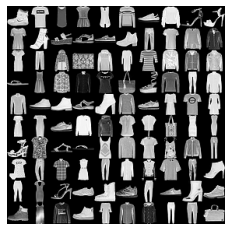

Labels
MNIST: [0 1 2 3 4 5 6 7 8 9]
FashionMNIST: [10 11 12 13 14 15 16 17 18 19]


In [18]:
plt_img = np.zeros((280, 280))
for i in range(10):
  for j in range(10):
    plt_img[i*28:(i+1)*28, j*28:(j+1)*28] = np.squeeze(x_train_fmnist[i*10+j])
plt.imshow(plt_img, cmap="gray")
plt.axis("off")
plt.show()

print("Labels")
print("MNIST: "+str(np.unique(y_test_mnist)))
print("FashionMNIST: "+str(np.unique(y_test_fmnist)))

Now the data is prepared we need to define a new model that can classify images into $20$ different classes. This is necessary since the models we used up to this point only have $10$ neurons in their output layers and therefore are only capable of classifying into $10$ different categories.

In [19]:
""" We implement a new model, which is capable of classifying 20 classes, with two conv. layers with 8/16 filters of size 3x3 and a stride of 2, a dropout layer between the conv. and dense layers with a droprate of 0.25 
three dense layers with 128/64/20 neurons."""

class MyExtendedModel(k.Model):
    def __init__(self):
        super(MyExtendedModel, self).__init__()
        # Layer definition
        self.conv0 = tf.keras.layers.Conv2D(8, 3, strides=2,activation='relu')                              
        self.conv1 = tf.keras.layers.Conv2D(16, 3, strides=2,activation='relu')                             
        self.flatten = tf.keras.layers.Flatten()                                                            
        self.dropout = tf.keras.layers.Dropout(0.25)                                                          
        self.dense0 = tf.keras.layers.Dense(128, activation='relu')                                        
        self.dense1 = tf.keras.layers.Dense(64, activation='relu')                                         
        self.dense2 = tf.keras.layers.Dense(20, activation='softmax')                                      


    def call(self, inputs, training=False):
        # Call layers in correct order to implement forward pass
        output = self.conv0(inputs)
        output = self.conv1(output)
        output = self.flatten(output) 
        output = self.dropout(output, training=training)
        output = self.dense0(output)
        output = self.dense1(output)
        output = self.dense2(output)
        return output

With this model we are almost redy to start training on a sequence of tasks, i.e. we will first train on the MNIST data set in order to learn the classes $0$ up to $9$ and after that train on the FshionMNIST data set in order to learn the remaining classes from $10$ to $19$. During this process we want to evaluate the model separately on MNIST and FashionMNIST validation data. Since this is not a standard procedure, we need to implement a Callback class. Callbacks in Keras are used to implement actions that are executed at different points during the training process, e.g. at the beginning of the training, after a batch is processed or at the end of each epoch. See the [documentation](https://www.tensorflow.org/versions/r2.2/api_docs/python/tf/keras/callbacks) for an overview of all provided callbacks and the [guide](https://www.tensorflow.org/beta/guide/keras/custom_callback#an_overview_of_callback_methods) on writing custom callbacks. While there are predefined callbacks, e.g. for logging metrics into a tensorboard log file, there is unfortunately no callback that we could use to evaluate our model simultaneously on two different validation data sets. The only option we have is to implement our own callback.

In [20]:
""" Implement a custom callback that evaluates a model on two data sets at the end of an epoch and stores the results in a two separate lists. """

class MyCallback(tf.keras.callbacks.Callback):
  # Get the two different data sets and create lists for storing results
  def __init__(self, x_0, y_0, x_1, y_1, batch_size):
    super(MyCallback, self).__init__()
    self.x_0 = x_0
    self.y_0 = y_0
    self.x_1 = x_1
    self.y_1 = y_1
    self.loss_0 = []
    self.acc_0 = []
    self.loss_1 = []
    self.acc_1 = []
    self.batch_size = 32
    
  def on_epoch_end(self, epoch, logs=None):
    # Evaluate the model on both data sets and store results
    print("\nStarting callback...")
    print("+----------------------+")
    print("| Data set 0           |")
    print("+----------------------+")
    metrics_0 = self.model.evaluate(self.x_0, self.y_0, batch_size=self.batch_size, verbose=1)#Evaluate the model on "self.x_0" and "self.y_0" with "self.batch_size"
    self.loss_0.append(metrics_0[0])
    self.acc_0.append(metrics_0[1])  # Append loss to the loss list "self.loss_0" and accuracy to the accuracy list "self.acc_0"
    print("+----------------------+")
    print("| Data set 1           |")
    print("+----------------------+")
    metrics_1 = self.model.evaluate(self.x_1, self.y_1, batch_size=self.batch_size, verbose=1)#Evaluate the model on "self.x_1" and "self.y_1" with "self.batch_size"
    self.loss_1.append(metrics_1[0])
    self.acc_1.append(metrics_1[1])# Append loss to the loss list "self.loss_1" and accuracy to the accuracy list "self.acc_1"
    print("Callback completed...")

This callback will accept two data sets on its initialization that can be used during training to evaluate on. For this we override the on_epoch_end function to evaluate on both data sets, print the results and store them for later use. We now train our neural network first on MNIST in order to learn the classes $\lbrace0,\ldots,9\rbrace$ and then on FashionMNIST in order to learn the classes $\lbrace10,\ldots,19\rbrace$  while simultaneously evaluating the model on both, the MNIST and FashionMNIST test sets. If our neural network would be capable of learning continually, we would expect to see the loss on MNIST decrease as we train on it and remain low as we continue with the training on FashionMNIST. Similarly we would expect the accuracy to rise on MNIST as we train on it and remain stable even if we continue to train on FashionMNIST.

In [21]:
""" Instantiate a MyExtendedModel object and train the models"""

extended_mdl = MyExtendedModel()
extended_opt = k.optimizers.RMSprop(learning_rate=learning_rate)
extended_mdl.compile(loss="sparse_categorical_crossentropy", optimizer=extended_opt, metrics=["accuracy"])

my_cb = MyCallback(x_test_mnist, y_test_mnist, x_test_fmnist, y_test_fmnist, batch_size)

extended_mdl.fit(x_train_mnist, y_train_mnist, batch_size=batch_size, epochs=epochs, callbacks=[my_cb]) # Train on MNIST
extended_mdl.fit(x_train_fmnist, y_train_fmnist, batch_size=batch_size, epochs=epochs, callbacks=[my_cb]) # Train on FashionMNIST

Epoch 1/20
469/469 [==============================] - ETA: 0s - loss: 0.7833 - accuracy: 0.8502
Starting callback...
+----------------------+
| Data set 0           |
+----------------------+
313/313 [==============================] - 1s 3ms/step - loss: 0.1327 - accuracy: 0.9574
+----------------------+
| Data set 1           |
+----------------------+
313/313 [==============================] - 1s 3ms/step - loss: 14.7123 - accuracy: 0.0000e+00
Callback completed...
469/469 [==============================] - 5s 10ms/step - loss: 0.7833 - accuracy: 0.8502
Epoch 2/20
461/469 [============================>.] - ETA: 0s - loss: 0.1584 - accuracy: 0.9512
Starting callback...
+----------------------+
| Data set 0           |
+----------------------+
313/313 [==============================] - 1s 3ms/step - loss: 0.0829 - accuracy: 0.9715
+----------------------+
| Data set 1           |
+----------------------+
313/313 [==============================] - 1s 3ms/step - loss: 17.0560 - accuracy:

To visualise catestrophic forgetting we now plot the loss on the test sets during the sequential training process on MNIST and FashionMNIST.

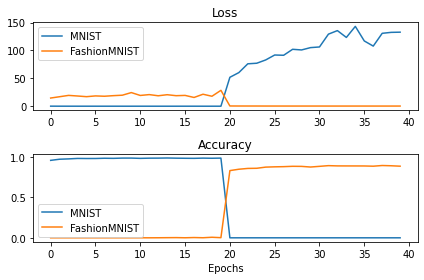

In [22]:
plt.subplot(2, 1, 1)
plt.plot(my_cb.loss_0)
plt.plot(my_cb.loss_1)
plt.legend(["MNIST", "FashionMNIST"])
plt.title("Loss")
plt.subplot(2, 1, 2)
plt.plot(my_cb.acc_0)
plt.plot(my_cb.acc_1)
plt.legend(["MNIST", "FashionMNIST"])
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.tight_layout()
plt.show()